In [47]:
import torch
import numpy as np
import seaborn as sns

##  example code

In [30]:
def create_bigbird_attention_mask(seq_length, block_size, num_global_blocks, num_random_blocks, num_attention_heads):
    # Initialize the attention mask with zeros
    attention_mask = torch.zeros(seq_length, seq_length)

    # Global attention for the first num_global_blocks
    attention_mask[:num_global_blocks, :] = 1
    attention_mask[:, :num_global_blocks] = 1

    # Sliding window attention
    for i in range(seq_length):
        start = max(i - block_size, 0)
        end = min(i + block_size + 1, seq_length)
        attention_mask[i, start:end] = 1

    # Random attention for each head
    np.random.seed(42)  # For reproducibility
    for _ in range(num_attention_heads):
        # Randomly select num_random_blocks for each head
        rand_indices = np.random.choice(seq_length, num_random_blocks, replace=False)
        for idx in rand_indices:
            attention_mask[idx, :] = 1  # Random row attends to all
            attention_mask[:, idx] = 1  # All attend to random column

    return attention_mask

In [31]:
# Example configuration
seq_length = 100  # Sequence length
block_size = 3  # Size of the sliding window
num_global_blocks = 2  # Number of tokens with global attention
num_random_blocks = 3  # Number of random attention blocks
num_attention_heads = 1  # Number of attention heads

# Creating the attention mask
attention_mask = create_bigbird_attention_mask(seq_length, block_size, num_global_blocks, num_random_blocks, num_attention_heads)

# Example of how this attention mask might be used in a forward pass:
query = torch.randn(seq_length, 64)  # Query for one head, for example
key = torch.randn(seq_length, 64)    # Key for the same head

# Raw attention scores (before applying attention mask)
raw_attention_scores = torch.matmul(query, key.transpose(0, 1))

# Apply the attention mask
# We use a large negative number to mask away attention; when the softmax is applied, these positions become zeros
masked_attention_scores = raw_attention_scores.masked_fill(attention_mask == 0, float('-inf'))

# Then apply softmax to get the attention probabilities
attention_probs = torch.nn.functional.softmax(masked_attention_scores, dim=1)

print(attention_probs)

tensor([[1.5654e-10, 1.2546e-12, 2.0112e-09,  ..., 2.4648e-06, 2.5993e-13,
         1.2830e-01],
        [6.1210e-07, 9.3141e-07, 1.1179e-06,  ..., 1.2751e-09, 1.1097e-06,
         6.5717e-10],
        [2.1760e-03, 6.4383e-06, 5.4840e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.3738e-05, 1.8445e-02, 0.0000e+00,  ..., 6.8687e-02, 7.2452e-06,
         1.0601e-08],
        [9.5753e-01, 4.7793e-08, 0.0000e+00,  ..., 1.2076e-02, 3.0388e-02,
         7.3762e-07],
        [1.2404e-04, 1.9241e-03, 0.0000e+00,  ..., 8.0633e-14, 2.4980e-07,
         3.7756e-08]])


<Axes: >

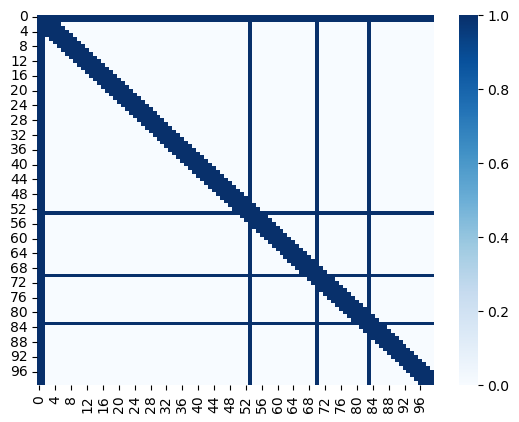

In [32]:
sns.heatmap(attention_mask.detach().numpy(), cmap='Blues', robust=True)

In [33]:
attention_mask.sum()

tensor(1610.)

## second version

In [68]:
import torch
import numpy as np

class BigBirdAttentionMask(nn.Module):
    def __init__(self, seq_len, block_size, num_global_blocks, num_rand_blocks, num_attention_heads):
        super().__init__()
        self.seq_len = seq_len
        self.block_size = block_size
        self.num_global_blocks = num_global_blocks
        self.num_rand_blocks = num_rand_blocks
        self.num_attention_heads = num_attention_heads

    def create_mask(self):
        # Initialize the attention mask to all zeros
        attention_mask = torch.zeros((self.num_attention_heads, self.seq_len, self.seq_len))

        # Global attention mask
        for head in range(self.num_attention_heads):
            attention_mask[head, :self.num_global_blocks, :] = 1
            attention_mask[head, :, :self.num_global_blocks] = 1
                
         # Sliding window attention
        for head in range(self.num_attention_heads):
            for i in range(0, self.seq_len):
                start = max(i - self.block_size, 0)
                end = min(i + self.block_size + 1, self.seq_len)
                attention_mask[head, i, start:end] = 1

        # Random attention mask - this couls be changed to have different number of random blocks calculated
        for head in range(self.num_attention_heads):
            for block in range(self.num_global_blocks, self.seq_len // self.block_size):
                # Select random blocks for this head and block
                rand_blocks = torch.randint(low=self.num_global_blocks, high=self.seq_len // self.block_size, 
                                            size=(self.num_rand_blocks,))

                # Set the mask for random blocks (convert block index to sequence index)
                block_start = block * self.block_size
                block_end = min(block_start + self.block_size, self.seq_len)
                for rand_block in rand_blocks:
                    rand_block_start = rand_block * self.block_size
                    rand_block_end = min(rand_block_start + self.block_size, self.seq_len)
                    attention_mask[head, block_start:block_end, rand_block_start:rand_block_end] = 1

        return attention_mask

# Example usage:
seq_len = 100
block_size = 3
num_global_blocks = 2
num_rand_blocks = 1
num_attention_heads = 1

attention_mask_creator = BigBirdAttentionMask(seq_len, block_size, num_global_blocks, num_rand_blocks, num_attention_heads)
attention_mask = attention_mask_creator.create_mask()
print("Attention mask shape:", attention_mask.shape)

Attention mask shape: torch.Size([1, 100, 100])


<Axes: >

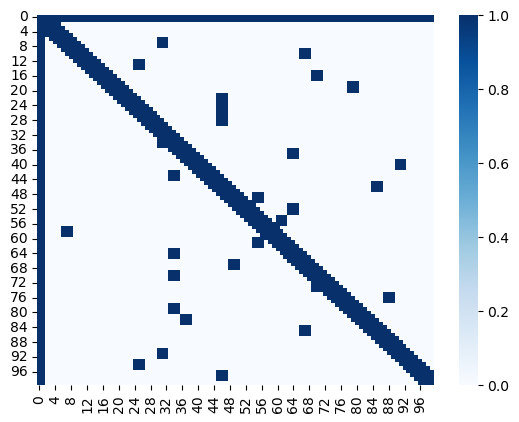

In [69]:
sns.heatmap(attention_mask.detach().numpy()[0], cmap='Blues', robust=True)

In [70]:
attention_mask.sum()

tensor(1319.)

In [77]:
torch.tensor(attention_mask.shape).prod()

tensor(10000)